<a href="https://colab.research.google.com/github/shyamsparrow/Jan-G4---NLP-Chatbot/blob/ALL_Models/LSTM%2BSimple%20Transformers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Capstone Project - NLP Chatbot

### DOMAIN: 
Industrial safety. NLP based Chatbot.

### CONTEXT:
The database comes from one of the biggest industry in Brazil and in the world. It is an urgent need for industries/companies around the globe to understand why employees still suffer some injuries/accidents in plants. Sometimes they also die in such environment.

### DATA DESCRIPTION:
This The database is basically records of accidents from 12 different plants in 03 different countries which every line in the data is an occurrence of an accident.

### Columns description:
* Data: timestamp or time/date information
* Countries: which country the accident occurred (anonymised)
* Local: the city where the manufacturing plant is located (anonymised)
* Industry sector: which sector the plant belongs to
* Accident level: from I to VI, it registers how severe was the accident (I means not severe but VI means very severe)
* Potential Accident Level: Depending on the Accident Level, the database also registers how severe the accident could have   been (due to other factors involved in the accident)
* Gender: if the person is male of female
* Employee or Third Party: if the injured person is an employee or a third party
* Critical Risk: some description of the risk involved in the accident
* Description: Detailed description of how the accident happened.

Link to download the dataset: https://drive.google.com/file/d/1_GmrRP1S2OIa02KlfOBNkYa8uxazGbfE/view?usp=sharing,
Original dataset link: https://www.kaggle.com/ihmstefanini/industrial-safety-and-health-analytics-database

### PROJECT OBJECTIVE:
Design a ML/DL based chatbot utility which can help the professionals to highlight the safety risk as per the incident description.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Replace the folder path with your drive folder path and clone the githb repo

In [2]:
%cd /content/drive/MyDrive/AIML/Capstone

/content/drive/MyDrive/AIML/Capstone


Run the below code for clone the repo in our Googele drive for first time

In [3]:
! git clone https://github.com/shyamsparrow/Jan-G4---NLP-Chatbot.git

fatal: destination path 'Jan-G4---NLP-Chatbot' already exists and is not an empty directory.


Change the Current folder into Github repo main folder, all the functions we are calling has to be in this repo.

In [4]:
%cd /content/drive/MyDrive/AIML/Capstone/Jan-G4---NLP-Chatbot

/content/drive/MyDrive/AIML/Capstone/Jan-G4---NLP-Chatbot


In [ ]:
!git checkout ALL_Models

Already on 'ALL_Models'
Your branch is up to date with 'origin/ALL_Models'.


In [ ]:
!git status

On branch ALL_Models
Your branch is up to date with 'origin/ALL_Models'.

Untracked files:
  (use "git add <file>..." to include in what will be committed)

	cache_dir/
	distilbert/
	runs/

nothing added to commit but untracked files present (use "git add" to track)


In [ ]:
!git pull

Already up to date.


Run this code to update the changes in repo to our drive

In [5]:
import warnings
warnings.filterwarnings('ignore')

import string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

## LSTM:

In [ ]:
industry_df = pd.read_csv("industry_df_with_stopwords.csv")

In [ ]:
from nltk.tokenize import word_tokenize
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import pickle

# Deep learning libraries
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense, LSTM,  Embedding, Dropout, Bidirectional, GlobalMaxPool1D

from keras.utils import np_utils
from keras.layers.merge import Concatenate
#from keras.utils import plot_model

from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

# Keras pre-processing
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [ ]:
# Select input and output features
X_text = industry_df['Description_preprocessed']
y_text = industry_df['Potential_Accident_Level']

In [ ]:
# Encode labels in column 'Potential Accident Level'and Convert into one-hot encoded vectors:
le = LabelEncoder()
le.fit(y_text)
y_text_le = le.transform(y_text)

In [ ]:
# Divide our data into testing and training sets:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text, y_text_le, test_size = 0.20, random_state = 1, stratify=y_text_le)

print('X_text_train shape : ({0})'.format(X_text_train.shape))
print('y_text_train shape : ({0},)'.format(y_text_train.shape))
print('X_text_test shape : ({0})'.format(X_text_test.shape))
print('y_text_test shape : ({0},)'.format(y_text_test.shape))

X_text_train shape : ((328,))
y_text_train shape : ((328,),)
X_text_test shape : ((83,))
y_text_test shape : ((83,),)


In [ ]:
print(np.bincount(y_text_train))
print(np.bincount(y_text_test))

[ 34  76  85 110  23]
[ 9 19 21 28  6]


In [ ]:
y_text_train = np_utils.to_categorical(y_text_train)
y_text_test = np_utils.to_categorical(y_text_test)

In [ ]:
# The first step in word embeddings is to convert the words into thier corresponding numeric indexes.
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_text_train)

X_text_train = tokenizer.texts_to_sequences(X_text_train)
X_text_test = tokenizer.texts_to_sequences(X_text_test)

In [ ]:
industry_df['nb_words'] = industry_df['Description_preprocessed'].apply(lambda x: len(x.split(' ')))

print('Minimum number of words: {}'.format(industry_df['nb_words'].min()))
print('Maximum number of words: {}'.format(industry_df['nb_words'].max()))

Minimum number of words: 16
Maximum number of words: 183


In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print("vocab_size:", vocab_size)

maxlen = 200

X_text_train = pad_sequences(X_text_train, padding='post', maxlen=maxlen)
X_text_test = pad_sequences(X_text_test, padding='post', maxlen=maxlen)

vocab_size: 2865


### Glove Embedding

In [ ]:
industry_df['sentence_length'].value_counts()

In [ ]:
X_text_train.shape

(328, 200)

In [ ]:
# Glove Vector
print('Indexing word vectors.')

embeddings_dictionary = {}
f = open('glove.6B.200d.txt', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_dictionary[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_dictionary))

In [ ]:
pickle.dump(embeddings_dictionary, open('/content/drive/MyDrive/AIML/Capstone/embeddings.pickle', 'wb'))

In [ ]:
infile = open('/content/drive/MyDrive/AIML/Capstone/embeddings.pickle','rb')
embeddings_dictionary = pickle.load(infile)

In [ ]:
def build_vocab(texts):
    sentences = texts.apply(lambda x: x.split()).values
    vocab = {}
    for sentence in sentences:
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [ ]:
len(vocab)

3449

In [ ]:
import operator 

def check_coverage(vocab, embeddings_index):
    known_words = {}
    unknown_words = {}
    nb_known_words = 0
    nb_unknown_words = 0
    for word in vocab.keys():
        try:
            known_words[word] = embeddings_index[word]
            nb_known_words += vocab[word]
        except:
            unknown_words[word] = vocab[word]
            nb_unknown_words += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(known_words) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(nb_known_words / (nb_known_words + nb_unknown_words)))
    unknown_words = sorted(unknown_words.items(), key=operator.itemgetter(1))[::-1]

    return unknown_words

In [ ]:
oov_glove = check_coverage(vocab, embeddings_dictionary)

Found embeddings for 93.97% of vocab
Found embeddings for  98.93% of all text


In [ ]:
embedding_size = 200

embedding_matrix = np.zeros((vocab_size, embedding_size))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
embedding_matrix.shape

(3446, 200)

### Base Model

In [ ]:
base_model = Sequential()
base_model.add(Embedding(vocab_size, output_dim=200, input_length=200, trainable=True))
#LSTM 
base_model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5)))
base_model.add(Dense(5, activation='softmax'))
base_model.compile(optimizer=optimizers.Adam(lr = 0.001), loss='binary_crossentropy', metrics=['acc'])

In [ ]:
base_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 200)          573000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              336896    
 nal)                                                            
                                                                 
 dense_2 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 911,181
Trainable params: 911,181
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=5)

#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

# fit the keras model on the dataset
base_model_history = base_model.fit(X_text_train, y_text_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_text_test, y_text_test), callbacks=[rlrp,callback])

Epoch 1/10
11/11 [==============================] - 50s 4s/step - loss: 0.5983 - acc: 0.2835 - val_loss: 0.4907 - val_acc: 0.3373 - lr: 0.0010
Epoch 2/10
11/11 [==============================] - 43s 4s/step - loss: 0.4807 - acc: 0.3384 - val_loss: 0.4745 - val_acc: 0.3373 - lr: 0.0010
Epoch 3/10
11/11 [==============================] - 52s 5s/step - loss: 0.4655 - acc: 0.3354 - val_loss: 0.4711 - val_acc: 0.3373 - lr: 0.0010
Epoch 4/10
11/11 [==============================] - 40s 4s/step - loss: 0.4624 - acc: 0.3811 - val_loss: 0.4711 - val_acc: 0.2892 - lr: 0.0010
Epoch 5/10
11/11 [==============================] - 39s 3s/step - loss: 0.4521 - acc: 0.4055 - val_loss: 0.4742 - val_acc: 0.3494 - lr: 0.0010
Epoch 6/10
11/11 [==============================] - 35s 3s/step - loss: 0.4277 - acc: 0.4238 - val_loss: 0.4783 - val_acc: 0.2651 - lr: 0.0010
Epoch 7/10
11/11 [==============================] - 36s 3s/step - loss: 0.4008 - acc: 0.5579 - val_loss: 0.4783 - val_acc: 0.2651 - lr: 1.0000

In [ ]:
_, train_accuracy = base_model.evaluate(X_text_train, y_text_train, batch_size=32, verbose=0)
_, test_accuracy = base_model.evaluate(X_text_test, y_text_test, batch_size=32, verbose=0)

print('Train accuracy: %.2f' % (train_accuracy*100))
print('Test accuracy: %.2f' % (test_accuracy*100))

Train accuracy: 55.18
Test accuracy: 26.51


In [ ]:
y_pred = base_model.predict(X_text_test, verbose=0) # Multiclass
y_pred_index = np.argmax(y_pred,axis=1)
y_original = np.argmax(y_text_test, axis =1)

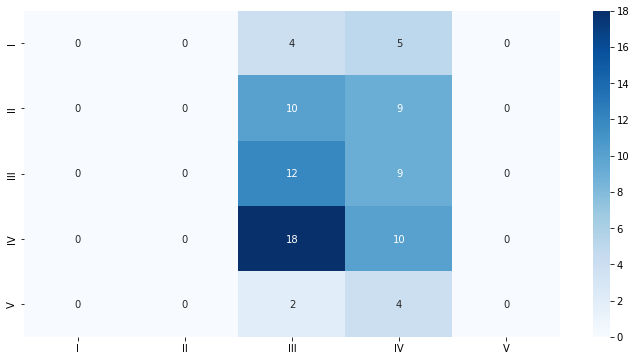

In [ ]:
cm = confusion_matrix(y_original,y_pred_index)
cm_label = ['I', 'II', 'III','IV', 'V']
plt.figure(figsize=(12,6))
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels = cm_label, yticklabels = cm_label);

In [ ]:
print(classification_report(y_original, y_pred_index))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00        19
           2       0.26      0.57      0.36        21
           3       0.27      0.36      0.31        28
           4       0.00      0.00      0.00         6

    accuracy                           0.27        83
   macro avg       0.11      0.19      0.13        83
weighted avg       0.16      0.27      0.19        83



### Complex LSTM Model:

In [ ]:

# Build a LSTM Neural Network
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 200, trainable=True)(deep_inputs)

LSTM_Layer_1 = Bidirectional(LSTM(128, return_sequences = True))(embedding_layer)
max_pool_layer_1 = GlobalMaxPool1D()(LSTM_Layer_1)
drop_out_layer_1 = Dropout(0.5, input_shape = (256,))(max_pool_layer_1)
dense_layer_1 = Dense(128, activation = 'relu')(drop_out_layer_1)
drop_out_layer_2 = Dropout(0.5, input_shape = (128,))(dense_layer_1)
dense_layer_2 = Dense(64, activation = 'relu')(drop_out_layer_2)
drop_out_layer_3 = Dropout(0.5, input_shape = (64,))(dense_layer_2)

dense_layer_3 = Dense(32, activation = 'relu')(drop_out_layer_3)
drop_out_layer_4 = Dropout(0.5, input_shape = (32,))(dense_layer_3)

dense_layer_4 = Dense(10, activation = 'relu')(drop_out_layer_4)
drop_out_layer_5 = Dropout(0.5, input_shape = (10,))(dense_layer_4)

dense_layer_5 = Dense(5, activation='softmax')(drop_out_layer_5)

lstm_model = Model(inputs=deep_inputs, outputs=dense_layer_5)

opt = optimizers.Adam(lr=0.001)
#opt = optimizers.SGD(lr=0.0001, momentum=0.9)
lstm_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

In [ ]:
print(lstm_model.summary())

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 200)]             0         
                                                                 
 embedding_24 (Embedding)    (None, 200, 200)          568200    
                                                                 
 bidirectional_11 (Bidirecti  (None, 200, 256)         336896    
 onal)                                                           
                                                                 
 global_max_pooling1d_2 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_54 (Dropout)        (None, 256)               0         
                                                                 
 dense_59 (Dense)            (None, 128)               328

In [ ]:
#callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3, min_delta=1E-2)
#rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.01, patience=3, min_delta=1E-2)
# metrics = Metrics(validation_data=(X_text_train, np.array(y_aug_train)))

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)

# fit the keras model on the dataset
base_model_history = lstm_model.fit(X_text_train, y_text_train, epochs=10, batch_size=32, verbose=1, validation_data=(X_text_test, y_text_test), callbacks=[callback])

Epoch 1/20
11/11 [==============================] - 12s 775ms/step - loss: 1.6006 - acc: 0.2683 - val_loss: 1.5869 - val_acc: 0.3735
Epoch 2/20
11/11 [==============================] - 7s 673ms/step - loss: 1.5687 - acc: 0.2835 - val_loss: 1.5516 - val_acc: 0.3735
Epoch 3/20
11/11 [==============================] - 7s 671ms/step - loss: 1.5928 - acc: 0.2835 - val_loss: 1.5448 - val_acc: 0.3735
Epoch 4/20
11/11 [==============================] - 8s 684ms/step - loss: 1.5631 - acc: 0.3140 - val_loss: 1.5428 - val_acc: 0.3735
Epoch 5/20
11/11 [==============================] - 7s 675ms/step - loss: 1.5709 - acc: 0.3018 - val_loss: 1.5314 - val_acc: 0.3735
Epoch 6/20
11/11 [==============================] - 7s 673ms/step - loss: 1.5609 - acc: 0.2683 - val_loss: 1.5173 - val_acc: 0.3735
Epoch 7/20
11/11 [==============================] - 7s 676ms/step - loss: 1.5447 - acc: 0.3079 - val_loss: 1.5124 - val_acc: 0.3735
Epoch 8/20
11/11 [==============================] - 7s 654ms/step - loss: 1

In [ ]:
with open('/content/drive/MyDrive/AIML/Capstone/parameters.pickle', "wb") as f:
  pickle.dump((le, tokenizer), f)

In [ ]:
lstm_model_json = lstm_model.to_json()
with open("LSTM_aug_model.json", "w") as json_file:
    json_file.write(lstm_model_json)
    
# serialize weights to HDF5
lstm_model.save_weights("LSTM_aug_model_weights.h5")
print("Saved model weights to disk")

# Save the model in h5 format 
lstm_model.save("LSTM_aug_model.h5")
print("Saved model to disk")

Saved model weights to disk
Saved model to disk


In [ ]:
# evaluate the keras model
_, train_accuracy = lstm_model.evaluate(X_text_train, y_text_train, batch_size=32, verbose=0)
_, test_accuracy = lstm_model.evaluate(X_text_test, y_text_test, batch_size=32, verbose=0)

print('Train accuracy: %.2f' % (train_accuracy*100))
print('Test accuracy: %.2f' % (test_accuracy*100))

Train accuracy: 33.33
Test accuracy: 34.55


In [ ]:
  with open('/content/drive/MyDrive/AIML/Capstone/Jan-G4---NLP-Chatbot/Utilities/result_df.csv', "rb") as f:
      result_df = pickle.load(f)

In [ ]:
y_pred = lstm_model.predict(X_text_test, verbose=0) # Multiclass
y_pred_index = np.argmax(y_pred,axis=1)
y_original = np.argmax(y_text_test, axis =1)

In [ ]:
_,tr_accuracy = lstm_model.evaluate(X_text_train,y_text_train) 
_,te_accuracy = lstm_model.evaluate(X_text_test,y_text_test) 

F1_sre= f1_score(y_original,y_pred_index, average='micro')
tr_accuracy,te_accuracy,F1_sre

6/6 [==============================] - 1s 216ms/step - loss: 1.4804 - acc: 0.3455


(0.3333333432674408, 0.34545454382896423, 0.34545454545454546)

In [ ]:
result_df.loc[len(result_df.index)] = ['LSTM_Aug_Model', tr_accuracy, te_accuracy,F1_sre] 
result_df

,Model,Train_accuracy,Test_accuracy,F1_score
0,LogReg,0.890244,0.890244,0.373494
1,Naive Bayes,1.000000,1.000000,0.421687
2,KNN,0.591463,0.591463,0.361446
3,SVM,0.990854,0.990854,0.361446
4,Decision Tree,0.512195,0.512195,0.313253
5,RandomForest,0.612805,0.612805,0.373494
6,Bagging,1.000000,1.000000,0.373494
7,AdaBoost,0.393293,0.393293,0.349398
8,Gradient Boost,0.920732,0.920732,0.325301
9,XGBoost,0.951220,0.951220,0.313253


In [ ]:
with open('/content/drive/MyDrive/AIML/Capstone/Jan-G4---NLP-Chatbot/result_df.csv', "wb") as f:
  pickle.dump((result_df), f)

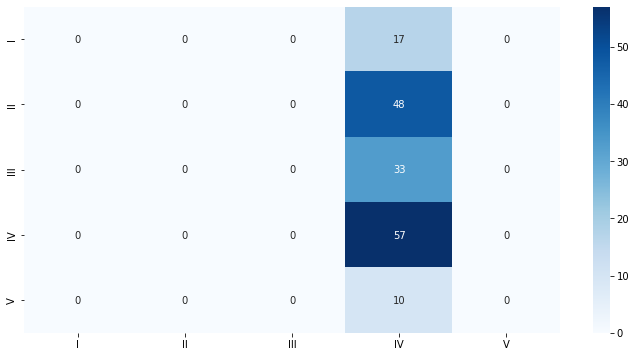

In [ ]:
cm = confusion_matrix(y_original,y_pred_index)
cm_label = ['I', 'II', 'III','IV', 'V']
plt.figure(figsize=(12,6))
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels = cm_label, yticklabels = cm_label);

In [ ]:
print(classification_report(y_original, y_pred_index))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        17
           1       0.00      0.00      0.00        48
           2       0.00      0.00      0.00        33
           3       0.35      1.00      0.51        57
           4       0.00      0.00      0.00        10

    accuracy                           0.35       165
   macro avg       0.07      0.20      0.10       165
weighted avg       0.12      0.35      0.18       165



Text(0.5, 1.0, 'Training and validation loss')

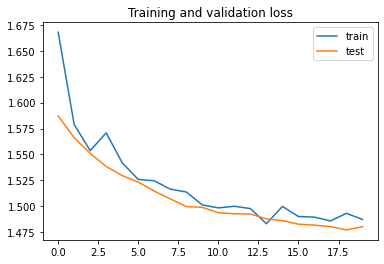

In [ ]:
epochs = range(len(training_history.history['loss'])) # Get number of epochs

# plot loss learning curves
plt.plot(epochs, training_history.history['loss'], label = 'train')
plt.plot(epochs, training_history.history['val_loss'], label = 'test')
plt.legend(loc = 'upper right')
plt.title ('Training and validation loss')

Text(0.5, 1.0, 'Training and validation accuracy')

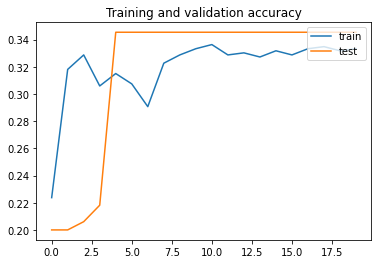

In [ ]:
# plot accuracy learning curves
plt.plot(epochs, training_history.history['acc'], label = 'train')
plt.plot(epochs, training_history.history['val_acc'], label = 'test')
plt.legend(loc = 'upper right')
plt.title ('Training and validation accuracy')

### Model Predictions:

In [ ]:
%cd /content/drive/MyDrive/AIML/Capstone

/content/drive/MyDrive/AIML/Capstone


In [ ]:
from keras.models import load_model
model = load_model('finalized_LSTM_model.h5')

In [ ]:
def model_prediction(usr_txt):
  with open('/content/drive/MyDrive/AIML/Capstone/parameters.pickle', "rb") as f:
      lab_en, tokenizer_data = pickle.load(f)
  from NLP_text_preprocess import PreProcessing
  pp = PreProcessing(to_lower = config.to_lower,remove_url=config.remove_url,
                   remove_time = config.remove_time,expand_contraction =config.expand_contraction,
                   remove_special_character=config.remove_special_character,
                   remove_punctuation=config.remove_punctuation,
                   remove_whitespace=config.remove_whitespace,
                   keep_alpha_numeric = False,
                   check_spelling=config.check_spelling,
                   remove_stopword=False,
                   lemmatize_word=config.lemmatize_word)

  pre_txt = pp.preprocess(usr_txt)
  tok_txt = tokenizer_data.texts_to_sequences([pre_txt])
  pad_txt = pad_sequences(tok_txt, padding='post', maxlen=185)
  prediction = model.predict(pad_txt, verbose=0)
  pred_index = np.argmax(prediction,axis=1)
  result = lab_en.inverse_transform(pred_index)[0]
  return print('The Potential accident level is', result)

In [ ]:
model_prediction(industry_df['Description_preprocessed'][1])

The Potential accident level is IV


## NLP Augmentation:

In [ ]:
try:
   import nlpaug.augmenter.word as naw
   import transformers
except ModuleNotFoundError:
  !pip install numpy requests nlpaug
  !pip install transformers
  import nlpaug.augmenter.word as naw
  import transformers

!pip uninstall pandas
!pip install pandas==1.1.5

In [ ]:
aug_bert = naw.ContextualWordEmbsAug(
    model_path='bert-base-uncased', action="substitute")

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/420M [00:00<?, ?B/s]

In [ ]:
industry_df = pd.read_csv("industry_df_with_stopwords.csv")

In [ ]:
# Select input and output features

X_text = industry_df['Description_preprocessed']
y_text = industry_df['Potential_Accident_Level']

In [ ]:
# Encode labels in column 'Potential Accident Level'and Convert into one-hot encoded vectors:
le = LabelEncoder()
le.fit(y_text)
y_text = le.transform(y_text)

In [ ]:
# Divide our data into testing and training sets:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(X_text, y_text, test_size = 0.20, random_state = 1, stratify = y_text)

In [ ]:
print(np.bincount(y_text_train))
print(np.bincount(y_text_test))

[ 34  76  85 110  23]
[ 9 19 21 28  6]


In [ ]:
y_text_train = np_utils.to_categorical(y_text_train)
y_text_test = np_utils.to_categorical(y_text_test)

In [ ]:
augmented_text = aug_bert.augment(industry_df['Description_preprocessed'][1])
print("Original:")
print(industry_df['Description_preprocessed'][1])
print("Augmented Text:")
print(augmented_text)

Original:
during the activation of a sodium sulphide pump the piping wa uncoupled and the sulfide solution wa designed in the area to reach the maid immediately she made use of the emergency shower and wa directed to the ambulatory doctor and later to the hospital note of sulphide solution 48 gram liter
Augmented Text:
during overnight activation of a sodium sulphide pump the piping wa uncoupled and the sulfide solution wa designed in hospital garden to reach the maid immediately patient made use of the sodium shower and wa directed to this ambulatory doctor and provided by the hospital solution of sulphide is 48 gram liter


In [ ]:
len(augmented_text)

310

In [ ]:
len(industry_df['Description_preprocessed'][1])

294

In [ ]:
aug_roberta = naw.ContextualWordEmbsAug(
    model_path='roberta-base', action="substitute")

Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

In [ ]:
augmented_text = aug_roberta.augment(industry_df['Description_preprocessed'][1])
print("Original:")
print(industry_df['Description_preprocessed'][1])
print("Augmented Text:")
print(augmented_text)

Original:
during the activation of a sodium sulphide pump the piping wa uncoupled and the sulfide solution wa designed in the area to reach the maid immediately she made use of the emergency shower and wa directed to the ambulatory doctor and later to the hospital note of sulphide solution 48 gram liter
Augmented Text:
during the activation of sodium sodium sulphide gas in piping wa uncoupled hence the sulfide solution wa designed in a area to reach the maid immediately she made use of a emergency shower water wa directed to the ambulatory doctor and later w see hospital note of sulphide solution 48 the liter


In [ ]:
X_aug_train = X_text_train.apply(lambda x: aug_roberta.augment(x))

In [ ]:
import pickle
pickle.dump(X_aug_train, open('/content/drive/MyDrive/AIML/Capstone/X_aug_train.pickle', 'wb'))

In [ ]:
infile = open('/content/drive/MyDrive/AIML/Capstone/X_aug_train.pickle','rb')
X_aug = pickle.load(infile)

In [ ]:
X_aug_train =[]
X_aug_train = X_text_train.tolist() + X_aug.tolist()
len(X_aug_train)

656

In [ ]:
y_aug_train = y_text_train.tolist() + y_text_train.tolist()
len(y_aug_train)

656

In [ ]:
X_aug_train = np.array(X_aug_train)
y_aug_train = np.array(y_aug_train)

In [ ]:
# The first step in word embeddings is to convert the words into thier corresponding numeric indexes.
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_aug_train)

X_text_train = tokenizer.texts_to_sequences(X_aug_train)
X_text_test = tokenizer.texts_to_sequences(X_text_test)

In [ ]:
vocab_size = len(tokenizer.word_index) + 1
print("vocab_size:", vocab_size)

maxlen = 200

X_text_train = pad_sequences(X_text_train, padding='post', maxlen=maxlen)
X_text_test = pad_sequences(X_text_test, padding='post', maxlen=maxlen)

vocab_size: 3439


In [ ]:
y_text_train = y_aug_train

In [ ]:
X_text_train.shape,y_text_train.shape,X_text_test.shape, y_text_test.shape

((656, 200), (656, 5), (83, 200), (83, 5))

In [ ]:
import pickle
pickle.dump((X_text_train,y_text_train,X_text_test,y_text_test), open('/content/drive/MyDrive/AIML/Capstone/Train_Test_augment.pickle', 'wb'))

In [ ]:
infile = open('/content/drive/MyDrive/AIML/Capstone/Train_Test_augment.pickle','rb')
X_train,y_train,X_test,y_test = pickle.load(infile)

In [ ]:
base_model = Sequential()
base_model.add(Embedding(vocab_size, output_dim=200, input_length=200, trainable=True))
#LSTM 
base_model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5)))
base_model.add(Dense(5, activation='softmax'))
base_model.compile(optimizer=optimizers.Adam(lr = 0.001), loss='categorical_crossentropy', metrics=['acc'])

In [ ]:
base_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 200, 200)          687800    
                                                                 
 bidirectional_4 (Bidirectio  (None, 256)              336896    
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 5)                 1285      
                                                                 
Total params: 1,025,981
Trainable params: 1,025,981
Non-trainable params: 0
_________________________________________________________________


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, min_delta=0.001)
#rlrp = ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1,factor=0.5, min_lr=0.00001)

# fit the keras model on the dataset
base_model_history = base_model.fit(X_train,y_train, epochs=20, batch_size=32, verbose=1, validation_data=(X_test,y_test), callbacks=[callback])

Epoch 1/20
21/21 [==============================] - 82s 4s/step - loss: 1.5136 - acc: 0.3064 - val_loss: 1.4912 - val_acc: 0.3373
Epoch 2/20
21/21 [==============================] - 67s 3s/step - loss: 1.4252 - acc: 0.3491 - val_loss: 1.4654 - val_acc: 0.3614
Epoch 3/20
21/21 [==============================] - 68s 3s/step - loss: 1.2169 - acc: 0.5427 - val_loss: 1.5208 - val_acc: 0.3133
Epoch 4/20
21/21 [==============================] - 65s 3s/step - loss: 0.8232 - acc: 0.7149 - val_loss: 1.6603 - val_acc: 0.3012
Epoch 5/20
21/21 [==============================] - 66s 3s/step - loss: 0.4662 - acc: 0.8674 - val_loss: 2.0560 - val_acc: 0.3253


In [ ]:
base_model.save("LSTM_Base_aug_model.h5")

In [ ]:
_, train_accuracy = base_model.evaluate(X_train,y_train, batch_size=8, verbose=0)
_, test_accuracy = base_model.evaluate(X_test,y_test, batch_size=8, verbose=0)

print('Train accuracy: %.2f' % (train_accuracy*100))
print('Test accuracy: %.2f' % (test_accuracy*100))

In [ ]:
y_pred = base_model.predict(X_test, verbose=0) # Multiclass
y_pred_index = np.argmax(y_pred,axis=1)
y_original = np.argmax(y_test, axis =1)

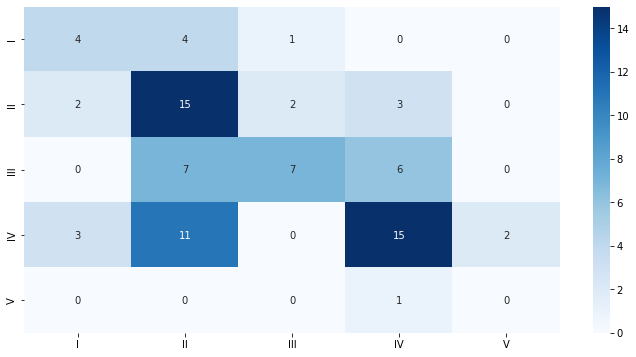

In [ ]:
cm = confusion_matrix(y_original,y_pred_index)
cm_label = ['I', 'II', 'III','IV', 'V']
plt.figure(figsize=(12,6))
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels = cm_label, yticklabels = cm_label);

In [ ]:
print(classification_report(y_original, y_pred_index))

              precision    recall  f1-score   support

           0       0.44      0.44      0.44         9
           1       0.41      0.68      0.51        22
           2       0.70      0.35      0.47        20
           3       0.60      0.48      0.54        31
           4       0.00      0.00      0.00         1

    accuracy                           0.49        83
   macro avg       0.43      0.39      0.39        83
weighted avg       0.55      0.49      0.50        83



In [ ]:

# Build a LSTM Neural Network
deep_inputs = Input(shape=(maxlen,))
embedding_layer = Embedding(vocab_size, 200, trainable=True)(deep_inputs)

LSTM_Layer_1 = Bidirectional(LSTM(units=128 , recurrent_dropout = 0.5 , dropout = 0.5))(embedding_layer)
#max_pool_layer_1 = GlobalMaxPool1D()(LSTM_Layer_1)
drop_out_layer_1 = Dropout(0.5, input_shape = (256,))(LSTM_Layer_1)
dense_layer_1 = Dense(128, activation = 'relu')(drop_out_layer_1)
drop_out_layer_2 = Dropout(0.5, input_shape = (128,))(dense_layer_1)
dense_layer_2 = Dense(64, activation = 'relu')(drop_out_layer_2)
drop_out_layer_3 = Dropout(0.5, input_shape = (64,))(dense_layer_2)

dense_layer_3 = Dense(32, activation = 'relu')(drop_out_layer_3)
drop_out_layer_4 = Dropout(0.5, input_shape = (32,))(dense_layer_3)

dense_layer_4 = Dense(10, activation = 'relu')(drop_out_layer_4)
drop_out_layer_5 = Dropout(0.5, input_shape = (10,))(dense_layer_4)

dense_layer_5 = Dense(5, activation='softmax')(drop_out_layer_5)

lstm_model = Model(inputs=deep_inputs, outputs=dense_layer_5)

opt = optimizers.Adam(lr=0.001)
#opt = optimizers.SGD(lr=0.0001, momentum=0.9)
lstm_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])

In [ ]:
lstm_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 200)]             0         
                                                                 
 embedding_7 (Embedding)     (None, 200, 200)          689200    
                                                                 
 bidirectional_6 (Bidirectio  (None, 256)              336896    
 nal)                                                            
                                                                 
 dropout_25 (Dropout)        (None, 256)               0         
                                                                 
 dense_26 (Dense)            (None, 128)               32896     
                                                                 
 dropout_26 (Dropout)        (None, 128)               0         
                                                           

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_acc', patience=3, min_delta=0.001)
# fit the keras model on the dataset X_text_train, np.array(y_aug_train)
training_history = lstm_model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1, validation_data=(X_test, y_test), callbacks=[callback])

Epoch 1/20
21/21 [==============================] - 36s 1s/step - loss: 1.5994 - acc: 0.2424 - val_loss: 1.5676 - val_acc: 0.3735
Epoch 2/20
21/21 [==============================] - 28s 1s/step - loss: 1.5978 - acc: 0.2881 - val_loss: 1.5646 - val_acc: 0.3012
Epoch 3/20
21/21 [==============================] - 27s 1s/step - loss: 1.5757 - acc: 0.2835 - val_loss: 1.5264 - val_acc: 0.3735
Epoch 4/20
21/21 [==============================] - 27s 1s/step - loss: 1.5733 - acc: 0.2835 - val_loss: 1.5349 - val_acc: 0.3735


In [ ]:
# evaluate the keras model
_, train_accuracy = lstm_model.evaluate(X_text_train, y_text_train, batch_size=8, verbose=0)
_, test_accuracy = lstm_model.evaluate(X_text_test, y_text_test, batch_size=8, verbose=0)

print('Train accuracy: %.2f' % (train_accuracy*100))
print('Test accuracy: %.2f' % (test_accuracy*100))

Train accuracy: 32.62
Test accuracy: 37.35


In [ ]:
y_pred = lstm_model.predict(X_text_test, verbose=0) # Multiclass
y_pred_index = np.argmax(y_pred,axis=1)
y_original = np.argmax(y_text_test, axis =1)

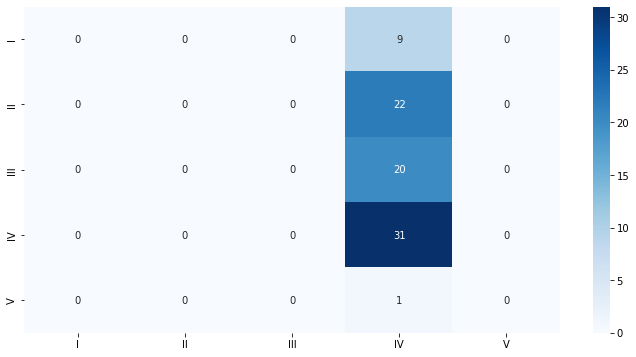

In [ ]:
cm = confusion_matrix(y_original,y_pred_index)
cm_label = ['I', 'II', 'III','IV', 'V']
plt.figure(figsize=(12,6))
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels = cm_label, yticklabels = cm_label);

In [ ]:
print(classification_report(y_original, y_pred_index))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         9
           1       0.00      0.00      0.00        22
           2       0.00      0.00      0.00        20
           3       0.37      1.00      0.54        31
           4       0.00      0.00      0.00         1

    accuracy                           0.37        83
   macro avg       0.07      0.20      0.11        83
weighted avg       0.14      0.37      0.20        83



## Transformer Models

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-4)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-4)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "att": self.att,
            "ffn": self.ffn,
            "layernorm1": self.layernorm1,
            "layernorm2": self.layernorm2,
            "dropout1": self.dropout1,
            "dropout2": self.dropout2,
        })
        return config

In [ ]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

    def get_config(self):
        config = super().get_config()
        config.update({
            "token_emb": self.token_emb,
            "pos_emb": self.pos_emb,
        })
        return config


In [ ]:
embed_dim = 300  # Embedding size for each token
num_heads = 5  # Number of attention heads
ff_dim = 200 # Hidden layer size in feed forward network inside transformer

inputs = layers.Input(shape=(200,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(5, activation="softmax")(x)


model = keras.Model(inputs=inputs, outputs=outputs)
print(model.summary())

Model: "model_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 300)         912300    
 g_7 (TokenAndPositionEmbedd                                     
 ing)                                                            
                                                                 
 transformer_block_7 (Transf  (None, 200, 300)         1926500   
 ormerBlock)                                                     
                                                                 
 global_average_pooling1d_7   (None, 300)              0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dropout_65 (Dropout)        (None, 300)               0  

In [ ]:
X_train.shape,y_train.shape,X_test.shape, y_test.shape

((656, 200), (656, 5), (83, 200), (83, 5))

In [ ]:
epochs = 50
batch_size = 32
loss = "categorical_crossentropy"
opt = keras.optimizers.Adam(lr=1e-3)

metrics = ["acc"]

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
rlrp = ReduceLROnPlateau(monitor='val_loss', factor=0.001, patience=3)
#callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.001)

model.compile(optimizer=opt, loss=loss, metrics=metrics)
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_test, y_test), callbacks = [rlrp,callback])

In [ ]:
model.save("Transformer_aug_model.h5")

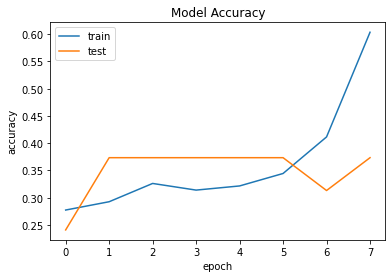

In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

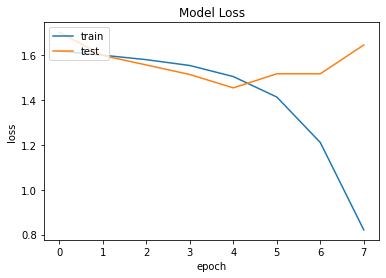

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
#predict the labels
y_predicted_labels = model.predict(X_text_test)

In [ ]:
y_pred_index = np.argmax(y_predicted_labels,axis=1)
y_original = np.argmax(y_text_test, axis =1)

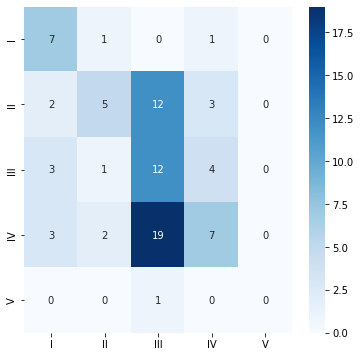

In [ ]:
#plot the confusion matrix
cm = confusion_matrix(y_original,y_pred_index)
cm_label = ['I', 'II', 'III','IV', 'V']
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels = cm_label, yticklabels = cm_label,fmt='g');

In [ ]:
print(classification_report(y_original, y_pred_index))

              precision    recall  f1-score   support

           0       0.47      0.78      0.58         9
           1       0.56      0.23      0.32        22
           2       0.27      0.60      0.37        20
           3       0.47      0.23      0.30        31
           4       0.00      0.00      0.00         1

    accuracy                           0.37        83
   macro avg       0.35      0.37      0.32        83
weighted avg       0.44      0.37      0.35        83



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.metrics import roc_auc_score

In [ ]:
y_predict = base_model.predict(X_test)

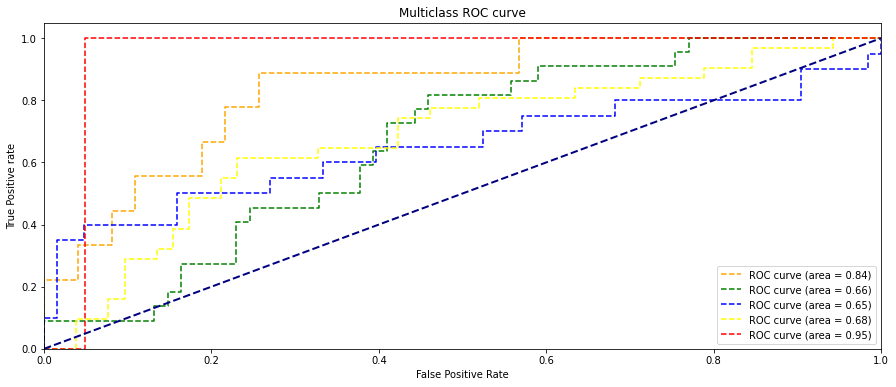

In [ ]:
fpr = {}
tpr = {}
#thresh ={}
roc_auc = dict()

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i],_ = roc_curve(y_test[:,i], y_predict[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plotting  
plt.figure(figsize=(15, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label="ROC curve (area = %0.2f)" % roc_auc[0])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label="ROC curve (area = %0.2f)" % roc_auc[1])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label="ROC curve (area = %0.2f)" % roc_auc[2])
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label= "ROC curve (area = %0.2f)" % roc_auc[3])
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label="ROC curve (area = %0.2f)" % roc_auc[4])

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])


plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc="lower right")
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);    

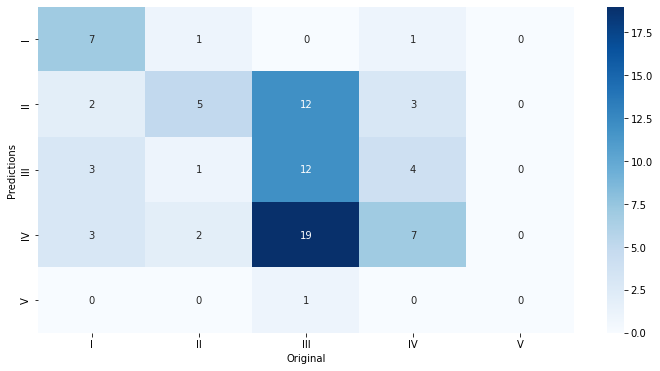

In [ ]:
cm = confusion_matrix(y_original,y_pred_index)
cm_label = ['I', 'II', 'III','IV', 'V']
plt.figure(figsize=(12,6))
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels = cm_label, yticklabels = cm_label);
plt.xlabel('Original');
plt.ylabel('Predictions');

In [ ]:
y_trans_predict = model.predict(X_test)

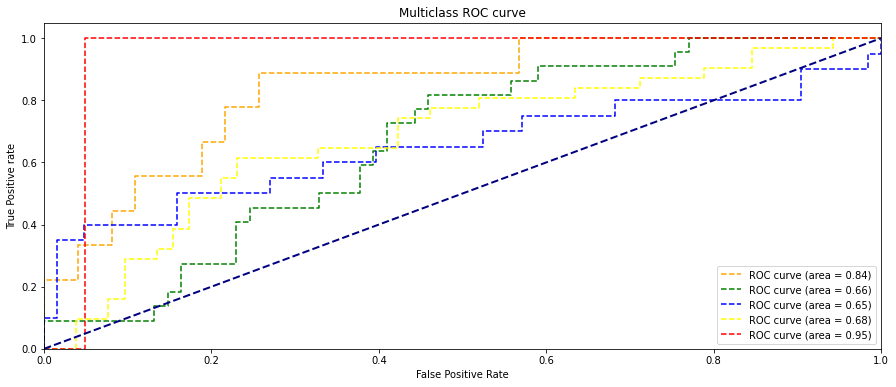

In [ ]:
fpr = {}
tpr = {}
#thresh ={}
roc_auc = dict()

n_class = 5

for i in range(n_class):    
    fpr[i], tpr[i],_ = roc_curve(y_test[:,i], y_trans_predict[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# plotting  
plt.figure(figsize=(15, 6))
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label="ROC curve (area = %0.2f)" % roc_auc[0])
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label="ROC curve (area = %0.2f)" % roc_auc[1])
plt.plot(fpr[2], tpr[2], linestyle='--',color='blue', label="ROC curve (area = %0.2f)" % roc_auc[2])
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label= "ROC curve (area = %0.2f)" % roc_auc[3])
plt.plot(fpr[4], tpr[4], linestyle='--',color='red', label="ROC curve (area = %0.2f)" % roc_auc[4])

plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])


plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc="lower right")
plt.legend(loc='best')
plt.savefig('Multiclass ROC',dpi=300);    

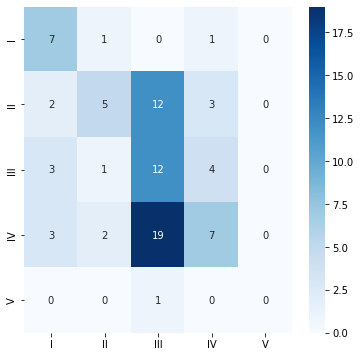

In [ ]:
#plot the confusion matrix
cm = confusion_matrix(y_original,y_pred_index)
cm_label = ['I', 'II', 'III','IV', 'V']
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, cmap='Blues',xticklabels = cm_label, yticklabels = cm_label,fmt='g');

In [ ]:
# save the model to disk
from keras.models import load_model
tr_model = load_model('Transformer_aug_model.h5')

## Transformer Models Distill Bert

In [ ]:
!pip install --upgrade simpletransformers

In [10]:
!pip show simpletransformers

Name: simpletransformers
Version: 0.63.3
Summary: An easy-to-use wrapper library for the Transformers library.
Home-page: https://github.com/ThilinaRajapakse/simpletransformers/
Author: Thilina Rajapakse
Author-email: chaturangarajapakshe@gmail.com
License: UNKNOWN
Location: /usr/local/lib/python3.7/dist-packages
Requires: tensorboard, sentencepiece, scipy, seqeval, transformers, datasets, numpy, streamlit, tqdm, pandas, requests, tokenizers, scikit-learn, regex, wandb
Required-by: 


In [11]:
industry_df = pd.read_csv("industry_df_with_stopwords.csv")

In [12]:
df = industry_df[['Description_preprocessed','Potential_Accident_Level']]
df['Potential_Accident_Level'] = df['Potential_Accident_Level'].astype('category').cat.codes

# For SimpleTransformers, the 'text' column should be the first column
df.columns = ['text','label'] # we need this for simpletransformers
df.head(2)

,text,label
0,while removing the drill rod of the jumbo 08 f...,3
1,during the activation of a sodium sulphide pum...,3


In [13]:
df['label'].value_counts()

3    138
2    106
1     95
0     43
4     29
Name: label, dtype: int64

In [14]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [15]:
from nltk.corpus import wordnet

# Define a function to find synonyms of words in a text. 
def get_synonyms(word):
    
    synonyms = set()
    
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").replace("-", " ").lower()
            synonym = "".join([char for char in synonym if char in ' qwertyuiopasdfghjklzxcvbnm'])
            synonyms.add(synonym) 
    if word in synonyms:
        synonyms.remove(word)
    
    return list(synonyms)

In [16]:
from nltk.corpus import stopwords

# create a list of stopwords(unnecessary words to be removed from the corpus)
stop_words = []
for w in stopwords.words('english'):
    stop_words.append(w)

In [17]:
import random

# Once the synonym is generated, we’ll define a function to replace the words in a sentence with their synonyms for a specified number of examples. 
def synonym_replacement(words, n):
    
    words = words.split()
    
    new_words = words.copy()
    random_word_list = list(set([word for word in words if word not in stop_words]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = get_synonyms(random_word)
        
        if len(synonyms) >= 1:
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
        
        if num_replaced >= n: #only replace up to n words
            break

    sentence = ' '.join(new_words)

    return sentence

In [18]:
trial_sent = df['text'][6]
print(trial_sent)

the collaborator report that he wa on street 09 holding in his left hand the volumetric balloon when he slipped and when placing his hand on the ground the volumetric balloon ended up breaking caused a small wound in his left hand


In [19]:
for n in range(3):
    print(f" Example of Synonym Replacement: {synonym_replacement(trial_sent,n)}")

 Example of Synonym Replacement: the collaborator report that he wa on street 09 holding in his left hand the volumetric balloon when he slipped and when post his hand on the ground the volumetric balloon ended up breaking caused a small wound in his left hand
 Example of Synonym Replacement: the collaborator report that he wa on street 09 holding in his left hand the volumetric balloon when he slipped and when come in his hand on the ground the volumetric balloon ended up breaking caused a small wound in his left hand
 Example of Synonym Replacement: the collaborator report that he wa on street 09 holding in his left hand the volumetric billow when he slipped and when placing his hand on the ground the volumetric billow ended up breaking caused a small wind up in his left hand


In [20]:
df_aug = df.copy()

In [21]:
augmented_sentences=[]
augmented_sentences_labels=[]


# Generate synthesized data for minority classes (II, III, IV and V) using the synonym_replacement(words, n) function.
for i in df_aug.index:
  if df_aug['label'][i]==1:  # Accident Level II
    for n in range(2):
      temps=synonym_replacement(df_aug['text'][i],n)
      augmented_sentences.append(temps)
      augmented_sentences_labels.append(df_aug['label'][i])
  elif df_aug['label'][i]==2:  # Accident Level III
    for n in range(2):
      temps=synonym_replacement(df_aug['text'][i],n)
      augmented_sentences.append(temps)
      augmented_sentences_labels.append(df_aug['label'][i])
  elif df_aug['label'][i]==3:  # Accident Level IV
    for n in range(1):
      temps=synonym_replacement(df_aug['text'][i],n)
      augmented_sentences.append(temps)
      augmented_sentences_labels.append(df_aug['label'][i])
  elif df_aug['label'][i]==4:  # Accident Level V
    for n in range(9):
      temps=synonym_replacement(df_aug['text'][i],n)
      augmented_sentences.append(temps)
      augmented_sentences_labels.append(df_aug['label'][i])
  elif df_aug['label'][i]==0:  # Accident Level V
    for n in range(5):
      temps=synonym_replacement(df_aug['text'][i],n)
      augmented_sentences.append(temps)
      augmented_sentences_labels.append(df_aug['label'][i])

In [22]:
# creating dataframes for augmented text and their labels
augmented_sentences = pd.DataFrame(augmented_sentences)
augmented_sentences_labels = pd.DataFrame(augmented_sentences_labels)

In [23]:
aug_df = pd.concat([augmented_sentences,augmented_sentences_labels], axis=1, ignore_index=True)
aug_df.rename(columns={0:'text',1:'label'}, inplace = True)
display(aug_df.head(2).append(aug_df.tail(2)))

,text,label
0,while removing the drill rod of the jumbo 08 f...,3
1,during the activation of a sodium sulphide tic...,3
1014,at when the supporter cleaned the floor of mod...,1
1015,at when the assistant cleaned the floor of mod...,1


In [24]:
df_aug = df_aug.append([aug_df], ignore_index=True)


In [25]:
df.shape, aug_df.shape, df_aug.shape


((411, 2), (1016, 2), (1427, 2))

In [26]:
def vis_countplot(self,x):
  plt.style.use("dark_background")
  plt.figure(figsize=(10,5))
  figure = sns.countplot(x, palette='autumn')
  figure.set_xticklabels(figure.get_xticklabels(),rotation=90)
  for p in figure.patches:
      height = p.get_height()
      figure.text(p.get_x()+p.get_width()/2., height + 0.1,height ,ha="center")

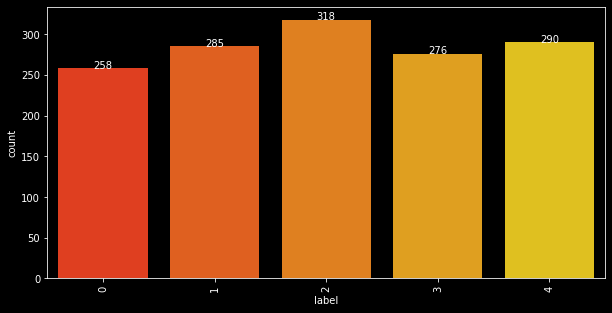

In [27]:
vis_countplot(df_aug,df_aug['label'])

In [28]:
first_column = df_aug.pop('text')
  
# insert column using insert(position,column_name, first_column) function
df_aug.insert(0, 'text', first_column)
  
df_aug.head(1)

,text,label
0,while removing the drill rod of the jumbo 08 f...,3


In [29]:
from sklearn.model_selection import train_test_split

target = 'label'

df_train, df_test = train_test_split(df_aug,test_size=0.2,
                                     random_state=55,
                                     stratify=df_aug[target])


print(f"df             : {df_aug.shape}")
print(f"\ndf_train : {df_train.shape}")
print(f"\ndf_test       : {df_test.shape}")

df_train.head(2)

df             : (1427, 2)

df_train : (1141, 2)

df_test       : (286, 2)


,text,label
1112,employee wa performing drilling activity with ...,2
300,being 0010 am at time when the collaborator wa...,2


In [30]:
df_train.label.value_counts()

2    254
4    232
1    228
3    221
0    206
Name: label, dtype: int64

In [31]:
df_test.label.value_counts()

2    64
4    58
1    57
3    55
0    52
Name: label, dtype: int64

In [32]:
import pickle
pickle.dump((df_train,df_test), open('/content/drive/MyDrive/AIML/Capstone/Transformers_train_test.pickle', 'wb'))

In [33]:
import pickle
infile = open('/content/drive/MyDrive/AIML/Capstone/Transformers_train_test.pickle','rb')
df_train,df_test = pickle.load(infile)

In [34]:
import torch
torch.cuda.is_available()

True

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()
#Standard output is '/device:GPU:0'

'/device:GPU:0'

In [35]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
import logging

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [36]:
!mkdir distilbert-New

In [37]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [139]:
model_type = 'distilbert'
model_name = 'distilbert-base-cased'


train_args = {
    "reprocess_input_data": True,
    "overwrite_output_dir": True,
    "use_cached_eval_features": True,

    #early stopping
    "early_stopping_delta": 0.01,
    "early_stopping_metric": "loss",
    "use_early_stopping": True,
    "early_stopping_metric_minimize": False,
    "early_stopping_patience": 3,
    "evaluate_during_training_steps": 500,

    # paths
    "output_dir": f"/content/drive/MyDrive/AIML/Capstone/Jan-G4---NLP-Chatbot/distilbert-New",

    # size
    "train_batch_size": 32, # 
    "max_seq_length": 200, # use small value to avoid OOM
    "num_train_epochs": 20,

    "wandb_project": "Chatbot_Distillbert-2",


    # rates
    # "weight_decay": 0,
    #"learning_rate": 4e-5,
    # "adam_epsilon": 1e-8,

    # evaluation
    "evaluate_during_training": False,
    "evaluate_during_training_steps": 500,
    "save_model_every_epoch": False,
    "save_eval_checkpoints": False,
    "eval_batch_size": 1,
    "gradient_accumulation_steps": 1,
}

In [140]:
%%time

model_distilbert = ClassificationModel(model_type, model_name, args=train_args,num_labels=5, use_cuda=True)

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier.wei

CPU times: user 1.45 s, sys: 268 ms, total: 1.72 s
Wall time: 9.85 s


In [141]:
model_distilbert.train_model(df_train, eval_df=None)

INFO:simpletransformers.classification.classification_utils: Converting to features started. Cache is not used.


  0%|          | 0/1141 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_utils: Saving features into cached file cache_dir/cached_train_distilbert_200_5_2


Epoch:   0%|          | 0/20 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for training.


Running Epoch 0 of 20:   0%|          | 0/36 [00:00<?, ?it/s]

Running Epoch 1 of 20:   0%|          | 0/36 [00:00<?, ?it/s]

Running Epoch 2 of 20:   0%|          | 0/36 [00:00<?, ?it/s]

Running Epoch 3 of 20:   0%|          | 0/36 [00:00<?, ?it/s]

Running Epoch 4 of 20:   0%|          | 0/36 [00:00<?, ?it/s]

Running Epoch 5 of 20:   0%|          | 0/36 [00:00<?, ?it/s]

Running Epoch 6 of 20:   0%|          | 0/36 [00:00<?, ?it/s]

Running Epoch 7 of 20:   0%|          | 0/36 [00:00<?, ?it/s]

Running Epoch 8 of 20:   0%|          | 0/36 [00:00<?, ?it/s]

Running Epoch 9 of 20:   0%|          | 0/36 [00:00<?, ?it/s]

Running Epoch 10 of 20:   0%|          | 0/36 [00:00<?, ?it/s]

Running Epoch 11 of 20:   0%|          | 0/36 [00:00<?, ?it/s]

Running Epoch 12 of 20:   0%|          | 0/36 [00:00<?, ?it/s]

Running Epoch 13 of 20:   0%|          | 0/36 [00:00<?, ?it/s]

Running Epoch 14 of 20:   0%|          | 0/36 [00:00<?, ?it/s]

Running Epoch 15 of 20:   0%|          | 0/36 [00:00<?, ?it/s]

Running Epoch 16 of 20:   0%|          | 0/36 [00:00<?, ?it/s]

Running Epoch 17 of 20:   0%|          | 0/36 [00:00<?, ?it/s]

Running Epoch 18 of 20:   0%|          | 0/36 [00:00<?, ?it/s]

Running Epoch 19 of 20:   0%|          | 0/36 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Training of distilbert model complete. Saved to /content/drive/MyDrive/AIML/Capstone/Jan-G4---NLP-Chatbot/distilbert-New.


(720, 0.1782145797131913)

In [ ]:
from simpletransformers.classification import ClassificationModel, ClassificationArgs
model_type = 'distilbert'
model_name = 'distilbert-base-cased'


In [142]:
load_model_distilbert = ClassificationModel(model_type, "/content/drive/MyDrive/AIML/Capstone/Jan-G4---NLP-Chatbot/distilbert-New", use_cuda=True,)

In [143]:
import sklearn
result_distilbert, model_outputs_distilbert, wrong_predictions_distilbert = load_model_distilbert.eval_model(df_test, 
                                                            acc = sklearn.metrics.accuracy_score)

INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_200_5_2


Running Evaluation:   0%|          | 0/286 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for evaluation.


Training loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁
global_step,▁▂▂▃▃▄▄▅▅▆▆▇▇█
lr,█▇▇▆▆▅▅▄▄▃▃▂▂▁
Training loss,0.00064
global_step,700
lr,0.0


INFO:simpletransformers.classification.classification_model:{'mcc': 0.9783924226872274, 'acc': 0.9825174825174825, 'eval_loss': 0.163581965686558}


In [144]:
result_distilbert

{'acc': 0.9825174825174825,
 'eval_loss': 0.163581965686558,
 'mcc': 0.9783924226872274}

In [145]:
model_outputs_distilbert.shape

(286, 5)

In [146]:
result_distilbert_train, model_outputs_distilbert_train, wrong_predictions_distilbert_train = load_model_distilbert.eval_model(df_train, 
                                                            acc = sklearn.metrics.accuracy_score)

INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_200_5_2


Running Evaluation:   0%|          | 0/286 [00:00<?, ?it/s]

INFO:simpletransformers.classification.classification_model: Initializing WandB run for evaluation.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.9783924226872274, 'acc': 0.9825174825174825, 'eval_loss': 0.163581965686558}


In [147]:
result_distilbert_train

{'acc': 0.9825174825174825,
 'eval_loss': 0.163581965686558,
 'mcc': 0.9783924226872274}

In [150]:
df_test

,level_0,index,text,label
0,0,164,during execution of drilling on the target bol...,3
1,1,1116,the collaborator completed the misalignment of...,1
2,2,349,the technician wa doing the magnetometric surv...,0
3,3,1401,the injured and his collaborator at the time o...,2
4,4,1290,the industrial cleaning worker cristian wa per...,1
...,...,...,...,...
281,281,1020,employee report that he performed an activenes...,1
282,282,803,in plant while doing work on geo pump reducer ...,3
283,283,605,the worker carried out the disassembly of 03 s...,2
284,284,1380,at 0400 i on 051917 the mechanic on duty of se...,1


In [151]:
# Displaying a sample prediction

sample_idx = 5

pred = (df_test['text'])

# Make predictions with the model
predictions, raw_outputs = load_model_distilbert.predict(pred)

print(f'Sampled Text: {df_test["text"].iloc[sample_idx]}')
print(f'True Class: {df_test["label"].iloc[sample_idx]}')
print(f'Predicted Class : {predictions[sample_idx]}')

INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_200_5_2


  0%|          | 0/286 [00:00<?, ?it/s]

Sampled Text: the employee who wa hitchhiking on the fuzz 403 truck equipment he crossed the central anterior of the track to catch the distinguish of the bicycle loader with some other operator who wa stopped in the opposite direction upon returning to the truck it wa hit in the branch left by the loader play out that wa traveling along the road and passed the cep403 on the right
True Class: 4
Predicted Class : 4


In [152]:
y_preds_distilbert, _, = load_model_distilbert.predict(df_test['text'])

INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_200_5_2


  0%|          | 0/286 [00:00<?, ?it/s]

In [153]:
result = pd.DataFrame({"Predicitons":y_preds_distilbert,"Actual":df_test['label']})
result

,Predicitons,Actual
0,3,3
1,1,1
2,0,0
3,2,2
4,1,1
...,...,...
281,1,1
282,3,3
283,2,2
284,1,1


In [154]:
# Displaying Confusion Matrix
from sklearn.metrics import confusion_matrix
def plot_cm(y_true, y_pred, title, figsize=(5,5)):
    cm = confusion_matrix(y_true, y_pred, labels=np.unique(y_true))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_true), columns=np.unique(y_true))
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap= "YlGnBu", annot=annot, fmt='', ax=ax)

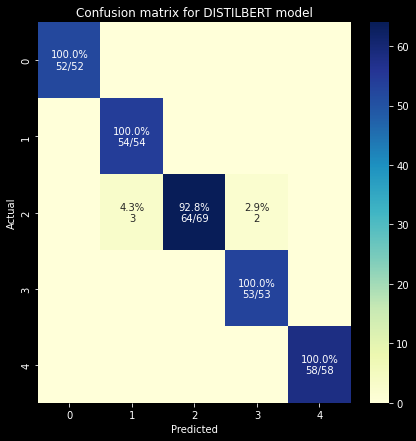

In [155]:
plot_cm(y_preds_distilbert, df_test['label'].values, 'Confusion matrix for DISTILBERT model', figsize=(7,7))

In [156]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, precision_score, roc_auc_score

model_performance = pd.DataFrame(columns=['Model', 'Test Accuracy', 'Test Loss','MCC', 'F1', 'Precision', 'Recall'])

In [157]:
model_performance = model_performance.append({'Model':'DistilBert with Data Augmentation',
                                              'Test Accuracy': result_distilbert['acc'],
                                              'Test Loss': result_distilbert['eval_loss'],
                                              'MCC': result_distilbert['mcc'],
                                              'F1' : f1_score(df_test['label'], y_preds_distilbert,average='micro'),
                                              'Precision': precision_score(df_test['label'], y_preds_distilbert,average='micro'),
                                              'Recall': recall_score(df_test['label'], y_preds_distilbert,average='micro'),                                  
                                              }, ignore_index=True)

model_performance

,Model,Test Accuracy,Test Loss,MCC,F1,Precision,Recall
0,DistilBert with Data Augmentation,0.982517,0.163582,0.978392,0.982517,0.982517,0.982517


In [161]:
sample =  [df_test['text'].iloc[10]]
sample

['being approximately in the no 1880 cx781 my kevin helper of jumbo 55 removed the drill rod that wa in the drilling hole instant that break the chain of subjection of the table of the drilling machine sliding down achieving rubbing the index finger of the left hand causing the injury']

In [162]:
pred, _, = load_model_distilbert.predict(sample)

INFO:simpletransformers.classification.classification_utils: Features loaded from cache at cache_dir/cached_dev_distilbert_200_5_2


  0%|          | 0/286 [00:00<?, ?it/s]

In [163]:
pred[0]

3

In [164]:
df_test['label'].iloc[10]

3

In [67]:
df_test

,index,text,label
0,164,during execution of drilling on the target bol...,3
1,1116,the collaborator completed the misalignment of...,1
2,349,the technician wa doing the magnetometric surv...,0
3,1401,the injured and his collaborator at the time o...,2
4,1290,the industrial cleaning worker cristian wa per...,1
...,...,...,...
281,1020,employee report that he performed an activenes...,1
282,803,in plant while doing work on geo pump reducer ...,3
283,605,the worker carried out the disassembly of 03 s...,2
284,1380,at 0400 i on 051917 the mechanic on duty of se...,1
